data available from:
http://groupware.les.inf.puc-rio.br/static/har/dataset-har-PUC-Rio-ugulino.zip

In [1]:
import graphlab as gl

In [2]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

[INFO] This trial license of GraphLab Create is assigned to birdmw@gmail.com and will expire on October 27, 2015. Please contact trial@dato.com for licensing options or to request a free non-commercial license for personal or academic use.

[INFO] Start server at: ipc:///tmp/graphlab_server-3110 - Server binary: /home/birdmw/anaconda/lib/python2.7/site-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1445386703.log
[INFO] GraphLab Server Version: 1.6.1


In [3]:
%matplotlib inline

In [4]:
gl.canvas.set_target('ipynb')
gl.canvas.set_target('browser')

In [23]:
def fix_data(data_frame):
    """
    Accepts a data_frame object - converts UK units to US. Ascribes proper data types, and drops one bad data point
    """
    data_frame = data_frame.drop(data_frame.index[[122076]]) #bad data point needs removal
    for col in ['user', 'gender', 'class']:
        data_frame[col] = data_frame[col].astype(str)
    for col in ['age', 'weight', 'x1', 'x2', 'x3', 'x4', 'y1', 'y2', 'y3', 'y4', 'z1', 'z2', 'z3', 'z4']:
        data_frame[col] = data_frame[col].astype(int)
    for col in ['how_tall_in_meters', 'body_mass_index']:
        data_frame[col] = data_frame[col].apply(lambda x: str(x).replace(".","").replace(",","."))
        data_frame[col] = data_frame[col].astype(float)
    return data_frame
        
def convert_columns_to_unique_ints(data_frame):
    '''
    Accepts a data_frame object
    replaces column values with unique integers representing each unique value.
    '''
    for col_name in ['user', 'gender', 'class']:
        original_values = data_frame[col_name].unique()
        new_values = range(len(original_values))
        print "converting", original_values
        print "into......", new_values
        data_frame[col_name] = data_frame[col_name].replace(original_values, new_values)
    return data_frame

def normalize(df, target):
    """
    Accepts data frame object and a target column (in our case it is "class")
    """
    result = df.copy()
    for feature_name in df.columns:
        if feature_name != target:
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

def pitch(x,y,z): #x,y,z = float, float, float
    """
    Accepts accelerometer readings from a device and returns a pitch angle
    """
    return math.atan( x / math.sqrt( y**2 + z**2 ) )

def roll(x,y,z): #x,y,z = float, float, float
    """
    Accepts accelerometer readings from a device and returns a roll angle
    """
    return math.atan( y / math.sqrt( x**2 + z**2 ) )

def add_pitch_roll(data_frame):
    """
    Accepts a data frame and returns a dataframe with new columns for the calculated roll and pitch angles"""
    result = data_frame.copy()
    for i in range(1,5):
        s = str(i)
        result['pitch'+s] = np.vectorize(pitch)(result['x'+s], result['y'+s], result['z'+s])
        result['roll'+s] = np.vectorize(roll)(result['x'+s], result['y'+s], result['z'+s])
    return result

def add_pitch_roll_diff(data_frame):
    """Accepts data frame
       returns data frame with new columns:
           difference between pitch/roll of sensors"""
    result = data_frame.copy()
    for i in range(1,5):
        for j in range(1,5):
            s1, s2 = str(i), str(j)
            if s1 != s2:
                result['pitchdiff'+s1+s2] = np.vectorize(np.subtract)(result['pitch'+s1], result['pitch'+s2])
                result['rolldiff'+s1+s2] = np.vectorize(np.subtract)(result['roll'+s1], result['roll'+s2])
    return result

def PCAIT(data_frame, n_features):
    """Accepts data_frame
    retuens data_frame
    which as been PCA reduced down to n_features"""
    result = data_frame.copy()
    target = result.pop('class')
    pca = PCA(n_components = n_features)
    pca.fit(result)
    result = pd.DataFrame(pca.transform(result))
    result['class'] = target.astype(str)
    return result

In [24]:
file_path = 'data/dataset-har-PUC-Rio-ugulino.csv'
df = pd.read_csv (file_path, delimiter =";")
df = fix_data(df) #call once per read_csv

In [25]:
df = convert_columns_to_unique_ints(df) 
df = add_pitch_roll(df)
df = add_pitch_roll_diff(df)
df = PCAIT(df, n_features=25)

converting ['debora' 'katia' 'wallace' 'jose_carlos']
into...... [0, 1, 2, 3]
converting ['Woman' 'Man']
into...... [0, 1]
converting ['sitting' 'sittingdown' 'standing' 'standingup' 'walking']
into...... [0, 1, 2, 3, 4]


In [26]:
print len(df)
df = df.dropna()
print len(df)
print df['class'].value_counts()
df.dtypes

165632
165631
0    50631
2    47370
4    43389
3    12414
1    11827
dtype: int64


0        float64
1        float64
2        float64
3        float64
4        float64
5        float64
6        float64
7        float64
8        float64
9        float64
10       float64
11       float64
12       float64
13       float64
14       float64
15       float64
16       float64
17       float64
18       float64
19       float64
20       float64
21       float64
22       float64
23       float64
24       float64
class     object
dtype: object

In [27]:
df = normalize(df, 'class' )
sf = gl.SFrame(data = df)   #turn data frame into GraphLab SFrame object
df['class'] = df['class'].astype(float).fillna(0).astype(int)


dtype('int64')

In [28]:
'''
#combining height with roll-pitch difference
for i in range(1,5):
    for j in range(1,5):
        print i, j
        s1, s2 = str(i), str(j)
        if s1 != s2:
            quadratic = gl.feature_engineering.create(sf, gl.feature_engineering.QuadraticFeatures(features = ['pitchdiff'+s1+s2, 'how_tall_in_meters']))
            sf = quadratic.transform(sf)
            quadratic = gl.feature_engineering.create(sf, gl.feature_engineering.QuadraticFeatures(features = ['rolldiff'+s1+s2, 'how_tall_in_meters']))
            sf = quadratic.transform(sf)
'''

"\n#combining height with roll-pitch difference\nfor i in range(1,5):\n    for j in range(1,5):\n        print i, j\n        s1, s2 = str(i), str(j)\n        if s1 != s2:\n            quadratic = gl.feature_engineering.create(sf, gl.feature_engineering.QuadraticFeatures(features = ['pitchdiff'+s1+s2, 'how_tall_in_meters']))\n            sf = quadratic.transform(sf)\n            quadratic = gl.feature_engineering.create(sf, gl.feature_engineering.QuadraticFeatures(features = ['rolldiff'+s1+s2, 'how_tall_in_meters']))\n            sf = quadratic.transform(sf)\n"

In [29]:
#sf.head()  # take a look at the new columns that have been added

BUILD A MODEL

In [80]:
### THIS CODE WILL TAKE A LONG TIME (5-10 minutes on a fast computer) ###
# This is a snippit of the tuning code I used to hone in on the best parameters for our model
# The actual seach involved tweaking these parameters many times


train, test = sf.random_split(.9)  # split data into a training and test set
params = dict([('target', 'class'),('max_iterations', [180, 170]),('max_depth', [9,8]),('step_size', [.3,.4]),
               ('column_subsample', [.65, .55]), ('row_subsample', [.85, .75])
              ])
job = gl.model_parameter_search.create((train, test), gl.boosted_trees_classifier.create, params)
job.get_results().sort('validation_accuracy')


# given parameters (see: params), cycle through them and find the best validation accuracy

[INFO] Validating job.
[INFO] Validation complete. Job: 'Model-Parameter-Search-Oct-21-2015-01-30-4000000' ready for execution
[INFO] Job: 'Model-Parameter-Search-Oct-21-2015-01-30-4000000' scheduled.
[INFO] Validating job.
[INFO] A job with name 'Model-Parameter-Search-Oct-21-2015-01-30-4000000' already exists. Renaming the job to 'Model-Parameter-Search-Oct-21-2015-01-30-4000000-89c71'.
[INFO] Validation complete. Job: 'Model-Parameter-Search-Oct-21-2015-01-30-4000000-89c71' ready for execution
[INFO] Job: 'Model-Parameter-Search-Oct-21-2015-01-30-4000000-89c71' scheduled.


model_id,column_subsample,max_depth,max_iterations,min_child_weight,min_loss_reduction,row_subsample,step_size
9,0.55,8,180,4,10,0.85,0.3
5,0.65,9,180,4,1,0.75,0.3
4,0.65,8,180,1,1,0.75,0.3
6,0.65,9,170,8,0,0.75,0.4
8,0.55,9,170,2,0,0.75,0.4
1,0.55,8,180,4,0,0.85,0.3
2,0.55,9,180,1,0,0.75,0.3
0,0.65,8,180,2,1,0.85,0.3
7,0.65,9,180,4,0,0.75,0.3
3,0.55,9,170,8,0,0.85,0.3


In [82]:
# take the best coefficients from the best row in the previous cell and build a model from it

train, test = sf.random_split(.9)  #randomly choose 10% of the data and set aside for model verification
model = gl.boosted_trees_classifier.create(train, target='class', column_subsample=.55, max_depth=9, 
                                           max_iterations=170, min_child_weight=8, min_loss_reduction=0,
                                           row_subsample=.85, step_size=.3)
# inspect the quality of the model
res = model.evaluate(test)
print res

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: Boosted trees classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 141799
PROGRESS: Number of classes           : 5
PROGRESS: Number of feature columns   : 18
PROGRESS: Number of unpacked features : 18
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter      Accuracy          Elapsed time
PROGRESS:         (training) (validation)
PROGRESS:      0   9.529e-01   9.509e-01        0.32s
PROGRESS:      1   9.677e-01   9.638e-01        0.75s
PROGRESS:      2   9.759e-01   9.738e-01        1.29s
PROGRESS:      3   9.810e-01   9.791e-01        1.89s
PROGRESS:      4   9.843e-01   9.813e-01        2.19s
PROGRESS:      5   9.854e-01   9.829e-01        2.53s
PROGRESS:      6   9.878e-01   9

In [83]:
# inspect the quality of the model
res = model.evaluate(test)
print res

{'confusion_matrix': Columns:
	target_label	int
	predicted_label	int
	count	int

Rows: 15

Data:
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      3       |        4        |   7   |
|      3       |        3        |  1239 |
|      1       |        2        |   2   |
|      2       |        4        |   11  |
|      3       |        2        |   3   |
|      4       |        3        |   5   |
|      4       |        2        |   3   |
|      0       |        0        |  5149 |
|      4       |        1        |   1   |
|      2       |        2        |  4766 |
+--------------+-----------------+-------+
[15 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns., 'accuracy': 0.9972146533454436}


Note the high accuracy of 99.72% beats out the best model of 99.6% seen on page 9 of this presentation:

http://groupware.les.inf.puc-rio.br/public/2012.SBIA.Ugulino.WearableComputing-Presentation.pdf


In [84]:
# record what features are important
i_feats = model.get_feature_importance()
f_imps = i_feats['count']

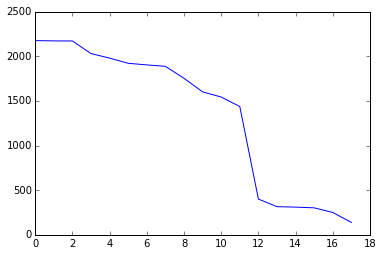

In [85]:
# Note that of the 50 features, some have high utility (2600 on the y-axis) and some have low utility (almost 0), but all of them are useful.
plt.plot(f_imps)

In [86]:
# Inspect that of the top features we see 
i_feats.print_rows(25)

+--------------------+-------+
|      feature       | count |
+--------------------+-------+
|         y2         |  2175 |
|         z1         |  2172 |
|         z2         |  2171 |
|         x4         |  2030 |
|         x3         |  1979 |
|         x2         |  1921 |
|         y3         |  1903 |
|         z3         |  1887 |
|         y4         |  1753 |
|         z4         |  1601 |
|         y1         |  1543 |
|         x1         |  1437 |
|        age         |  400  |
|        user        |  315  |
|  body_mass_index   |  310  |
| how_tall_in_meters |  302  |
|       weight       |  250  |
|       gender       |  139  |
+--------------------+-------+
[18 rows x 2 columns]



ROLL and PITCH compose many of the top features

Conclusion: We can say that feature engineering likely improved our model but to make sure we can run our model again without the feature engineering

In [43]:
df = pd.read_csv (file_path, delimiter =";")  #re-read in our data
df = fix_data(df)  # fix our data
df = convert_columns_to_unique_ints(df) # fix our data
sf = gl.SFrame(data = df)   #turn data frame into GraphLab SFrame object

converting ['debora' 'katia' 'wallace' 'jose_carlos']
into...... [0, 1, 2, 3]
converting ['Woman' 'Man']
into...... [0, 1]
converting ['sitting' 'sittingdown' 'standing' 'standingup' 'walking']
into...... [0, 1, 2, 3, 4]


In [44]:
train, test = sf.random_split(.9)  #randomly choose 10% of the data and set aside for model verification
model = gl.boosted_trees_classifier.create(train, target='class', column_subsample=.7, max_depth=9, 
                                           max_iterations=180, min_child_weight=1, min_loss_reduction=0,
                                           row_subsample=.7, step_size=.1)

PROGRESS: Creating a validation set from 5 percent of training data. This may take a while.
          You can set ``validation_set=None`` to disable validation tracking.

PROGRESS: Boosted trees classifier:
PROGRESS: --------------------------------------------------------
PROGRESS: Number of examples          : 141304
PROGRESS: Number of classes           : 5
PROGRESS: Number of feature columns   : 18
PROGRESS: Number of unpacked features : 18
PROGRESS: Starting Boosted Trees
PROGRESS: --------------------------------------------------------
PROGRESS:   Iter      Accuracy          Elapsed time
PROGRESS:         (training) (validation)
PROGRESS:      0   9.628e-01   9.556e-01        0.39s
PROGRESS:      1   9.751e-01   9.685e-01        0.71s
PROGRESS:      2   9.788e-01   9.745e-01        1.04s
PROGRESS:      3   9.813e-01   9.781e-01        1.37s
PROGRESS:      4   9.821e-01   9.803e-01        1.70s
PROGRESS:      5   9.836e-01   9.821e-01        2.05s
PROGRESS:      6   9.842e-01   9

In [45]:
# inspect the quality of the model
res = model.evaluate(test)
print res

{'confusion_matrix': Columns:
	target_label	int
	predicted_label	int
	count	int

Rows: 16

Data:
+--------------+-----------------+-------+
| target_label | predicted_label | count |
+--------------+-----------------+-------+
|      3       |        4        |   3   |
|      3       |        3        |  1252 |
|      1       |        2        |   2   |
|      2       |        4        |   3   |
|      3       |        2        |   5   |
|      1       |        3        |   7   |
|      4       |        3        |   2   |
|      4       |        2        |   7   |
|      0       |        0        |  5154 |
|      3       |        1        |   6   |
+--------------+-----------------+-------+
[16 rows x 3 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns., 'accuracy': 0.9973498765283383}


In [46]:
# record what features are important
i_feats = model.get_feature_importance()
f_imps = i_feats['count']

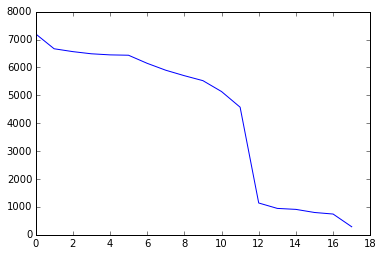

In [47]:
# Note that of the 50 features, some have high utility (2600 on the y-axis) and some have low utility (almost 0), but all of them are useful.
plt.plot(f_imps)

In [48]:
# Inspect that of the top features we see 
i_feats.print_rows(18)

+--------------------+-------+
|      feature       | count |
+--------------------+-------+
|         z1         |  7206 |
|         x4         |  6668 |
|         z2         |  6566 |
|         y2         |  6488 |
|         x3         |  6449 |
|         y3         |  6436 |
|         z3         |  6147 |
|         x2         |  5899 |
|         z4         |  5703 |
|         y1         |  5525 |
|         y4         |  5135 |
|         x1         |  4574 |
|        age         |  1140 |
|        user        |  946  |
| how_tall_in_meters |  911  |
|       weight       |  800  |
|  body_mass_index   |  744  |
|       gender       |  288  |
+--------------------+-------+
[18 rows x 2 columns]

